<a href="https://colab.research.google.com/github/Sarinda251/CAP_4630/blob/master/HW_4_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4, Problem 3, Notebook 1

Similar to the first notebook, the convnet I chose was Mobile net, and I added a small 2 by 2 maxpooling layer to the classifier to group chunks of pixels together. I added a dropout layer to try and help with overfitting

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 23:56:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   258MB/s    in 0.3s    

2020-04-21 23:57:00 (258 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG16 convolution base and custom densely connected layers

### Load the convolutional base

In [8]:
from keras.applications import MobileNet

conv_base = MobileNet(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 3s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 4,277,953
Trainable params: 1,049,089
Non-trainable params: 3,228,864
____________________________________

## Train the model end to end with frozen convolutional base

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 24s 242ms/step - loss: 0.6800 - acc: 0.7240 - val_loss: 0.0799 - val_acc: 0.9120
Epoch 2/30
100/100 [==============================] - 16s 161ms/step - loss: 0.4386 - acc: 0.8275 - val_loss: 0.0331 - val_acc: 0.9360
Epoch 3/30
100/100 [==============================] - 16s 160ms/step - loss: 0.3543 - acc: 0.8590 - val_loss: 0.5632 - val_acc: 0.9470
Epoch 4/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3707 - acc: 0.8615 - val_loss: 0.0936 - val_acc: 0.9520
Epoch 5/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3103 - acc: 0.8745 - val_loss: 0.0966 - val_acc: 0.9580
Epoch 6/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3251 - acc: 0.8605 - val_loss: 0.2717 - val_acc: 0.9580
Epoch 7/30
100/100 [==============================] - 16s 162ms/step - loss: 0.2744 - acc: 0.8990 - val_lo

## Display curves of loss and accuracy during training

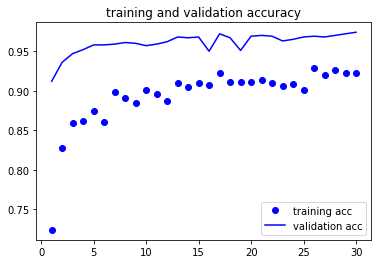

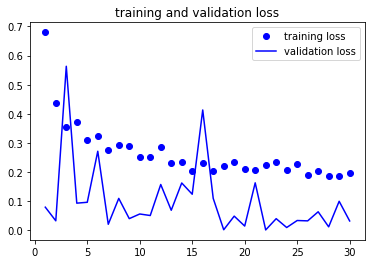

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [15]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 19s 186ms/step - loss: 0.1945 - acc: 0.9200 - val_loss: 0.0239 - val_acc: 0.9680
Epoch 2/100
100/100 [==============================] - 16s 162ms/step - loss: 0.1871 - acc: 0.9240 - val_loss: 0.1322 - val_acc: 0.9630
Epoch 3/100
100/100 [==============================] - 16s 163ms/step - loss: 0.1790 - acc: 0.9295 - val_loss: 0.0457 - val_acc: 0.9510
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 0.1807 - acc: 0.9260 - val_loss: 0.3738 - val_acc: 0.9630
Epoch 5/100
100/100 [==============================] - 16s 164ms/step - loss: 0.1884 - acc: 0.9295 - val_loss: 0.3416 - val_acc: 0.9570
Epoch 6/100
100/100 [==============================] - 16s 163ms/step - loss: 0.1701 - acc: 0.9295 - val_loss: 0.0500 - val_acc: 0.9580
Epoch 7/100
100/100 [==============================] - 16s 162ms/step - loss: 0.2083 - acc: 0.9175 - val_loss: 0.1832 - val_acc: 0.9600
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

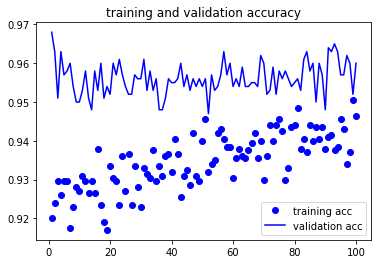

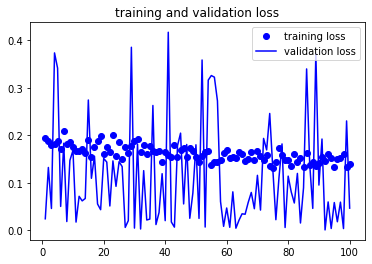

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [18]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.04635719582438469
Validation accuracy: 0.9599999785423279


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)